# Exploring NYC Trips

### Author: Cecília Assis
#### Github: https://github.com/ceciliassis
#### Linkedin: https://www.linkedin.com/in/ceciliassis/ 

## Questions to be answered

1. What is the average distance traveled by trips with a maximum of 2 passengers;
2. Which are the 3 biggest vendors based on the total amount of money raised;
3. Make a histogram of the monthly distribution over 4 years of rides paid with cash;
4. Make a time series chart computing the number of tips each day for the last 3 months of 2012.


## Downloading data

In [ ]:
!sh download_data.sh

## Exploring the data

### NYC Trips

In [ ]:
%%bash
for f in resources/*.json
do
    printf "+++++ Exploring $f\n\n"
    printf "+ NUMBER OF LINES\n\n"
    wc $f -l
    printf "\n+ HEAD \n\n"
    head $f -n 3
    printf "\n"
done

### Lookups

In [ ]:
%%bash
for f in resources/*.csv
do
    printf "+++++ Exploring $f\n\n"
    printf "+ NUMBER OF LINES\n\n"
    wc $f -l
    printf "\n+ HEAD \n\n"
    head $f -n 10
    printf "\n"
done

## Pre processing data

In [1]:
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment', None)

In [2]:
URLS_TABLE = {
    '2009': 'resources/data-sample_data-nyctaxi-trips-2009-json_corrigido.json',
    '2010': 'resources/data-sample_data-nyctaxi-trips-2010-json_corrigido.json',
    '2011': 'resources/data-sample_data-nyctaxi-trips-2011-json_corrigido.json',
    '2012': 'resources/data-sample_data-nyctaxi-trips-2012-json_corrigido.json'
}

URLS = URLS_TABLE.values()

PAYMENT_TYPE_TABLE = pd.read_csv('resources/data-payment_lookup-csv.csv')\
                       .rename(columns={'A':'payment_type', 'B': 'payment_lookup'}).drop(0, axis=0)
PAYMENT_TYPE_TABLE = dict(zip(PAYMENT_TYPE_TABLE['payment_type'], PAYMENT_TYPE_TABLE['payment_lookup']))

In [14]:
def clean_json(line, allowed_columns):
    return {col: value for col, value in json.loads(line).items() if col in allowed_columns}

def build_df(urls, allowed_columns, chunk_size=100000, chunk_processing_func=None):
    df = pd.DataFrame()

    for url in urls:
        for chunk in pd.read_json(url, lines=True, chunksize=chunk_size):
            df = pd.concat([chunk_processing_func(chunk[allowed_columns]), df])
            
    return df

def clear_memory():
    try:
        del df
    except NameError:
        pass

## Answering questions

### What is the average distance traveled by trips with a maximum of 2 passengers?

In [4]:
clear_memory()

def fn(df):
    df.loc[:, 'Year'] = df.loc[:, 'dropoff_datetime'].apply(lambda date: pd.Timestamp(date).year)
    
    cols = ['Year','passenger_count', 'trip_distance']
    
    return df.loc[df.loc[:, cols[1]] <= 2, cols].astype({'trip_distance': 'float32'})

df = build_df(URLS, ['dropoff_datetime', 'passenger_count', 'trip_distance'], chunk_processing_func=fn)

print(f'Average distance traveled by trips with a maximum of 2 passengers: {df["trip_distance"].mean()}')

Average distance traveled by trips with a maximum of 2 passengers: nan


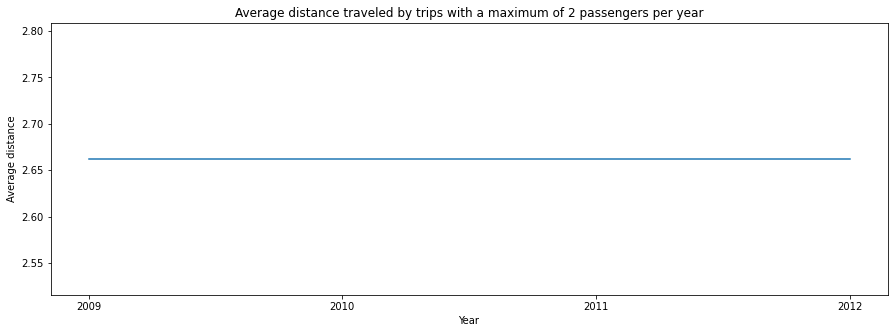

In [12]:
plt.close('all')

ax = plt.gca()

ax.set_ylabel('Average distance')

ax.ticklabel_format(style='plain')

kwargs = {
    'ax': ax,
    'kind': 'line',
    'title': 'Average distance traveled by trips with a maximum of 2 passengers per year', 
    'figsize': (15, 5),
    'xticks': df['Year'].unique()
}

df.groupby('Year').mean()['trip_distance'].plot(**kwargs)

plt.show()

### Which are the 3 biggest vendors based on the total amount of money raised?

In [16]:
clear_memory()

df = build_df(URLS, ['vendor_id', 'total_amount'],
              chunk_processing_func=lambda df: df.groupby('vendor_id').sum())

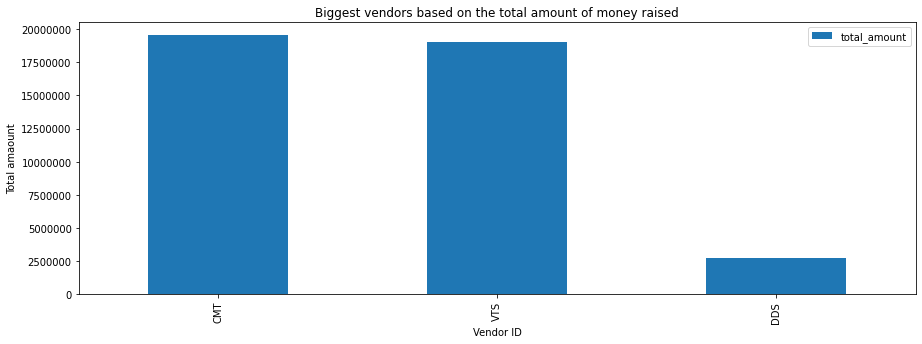

In [35]:
plt.close('all')

ax = plt.gca()

ax.set_ylabel('Total amaount')

ax.ticklabel_format(style='plain')

kwargs = {
    'ax': ax,
    'kind': 'bar',
    'title': 'Biggest vendors based on the total amount of money raised', 
    'figsize': (15, 5)
}

df.index.rename('Vendor ID', inplace=True)

df.groupby('Vendor ID').sum().sort_values(by=['total_amount'], ascending=False)\
                             .iloc[:3].plot(**kwargs)

plt.show()

### Make a histogram of the monthly distribution over 4 years of rides paid with cash

In [37]:
# Verify if pickup and dropoff day are always the same
clear_memory()

def fn(df):
    df.loc[:, 'dropoff_day'] = df.loc[:, 'dropoff_datetime'].apply(lambda date: pd.Timestamp(date).day)
    df.loc[:, 'pickup_day'] = df.loc[:, 'pickup_datetime'].apply(lambda date: pd.Timestamp(date).day)
    
    return df.loc[df.loc[:, 'dropoff_day'] != df.loc[:, 'pickup_day']]

df = build_df(URLS, ['pickup_datetime', 'dropoff_datetime'], chunk_processing_func=fn)

print(f'Number of trips that ended on the next day: {df.shape[0]}')

Number of trips that ended on the next day: 24098


In [39]:
# Since there are a fell trips that went over midnight, I'll use the dropoff day as trip day
clear_memory()

def processing_func(df):
    df.loc[:, 'dropoff_month'] = df.loc[:, 'dropoff_datetime'].apply(lambda date: pd.Timestamp(date).month)
    df.loc[:, 'payment_type'] = df.loc[:, 'payment_type'].map(PAYMENT_TYPE_TABLE)

    return df.loc[df.loc[:, 'payment_type'] == 'Cash']


df = build_df(URLS, ['payment_type', 'dropoff_datetime'], chunk_processing_func=processing_func)

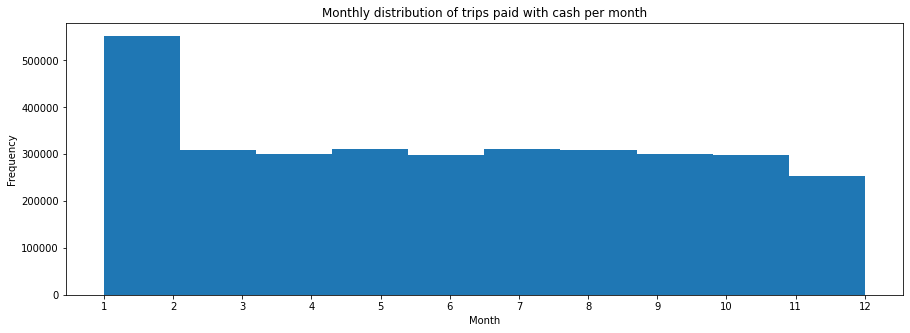

In [40]:
plt.close('all')

ax = plt.gca()

ax.set_xlabel('Month')

kwargs = {
    'ax': ax,
    'kind': 'hist',
    'title': 'Monthly distribution of trips paid with cash per month', 
    'figsize': (15, 5),
    'xticks': df['dropoff_month'].value_counts().index
}

df['dropoff_month'].plot(**kwargs)

plt.show()

### Make a time series chart computing the number of tips each day for the last 3 months of 2012

In [75]:
clear_memory()

def fn(df):
    df.loc[:, 'dropoff_day'] = df.loc[:, 'dropoff_datetime'].apply(lambda date: pd.Timestamp(date).day)
    df.loc[:, 'dropoff_month'] = df.loc[:, 'dropoff_datetime'].apply(lambda date: pd.Timestamp(date).month)
    
    return df.loc[df.loc[:, 'dropoff_month'].isin([10,11,12])]

df = build_df([URLS_TABLE['2012']], ['dropoff_datetime'], chunk_processing_func=fn)

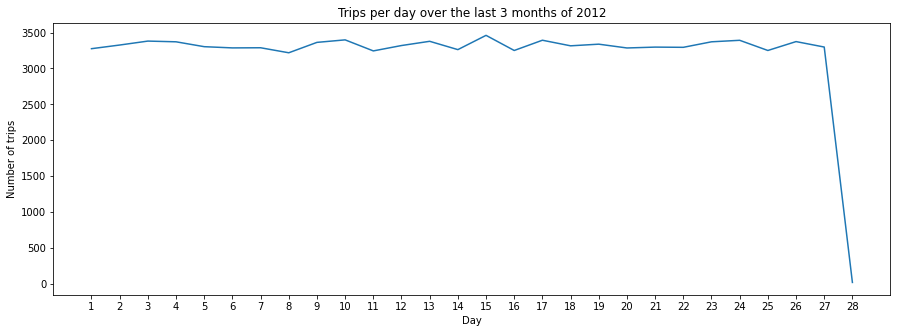

In [77]:
plt.close('all')

ax = plt.gca()

ax.set_xlabel('Day')
ax.set_ylabel('Number of trips')

kwargs = {
    'ax': ax,
    'kind': 'line',
    'title': 'Trips per day over the last 3 months of 2012', 
    'figsize': (15, 5),
    'xticks': df['dropoff_day'].value_counts().index
}

df['dropoff_day'].value_counts().sort_index().plot(**kwargs) 

plt.show()